In [47]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
session = SparkSession.builder.master("local[*]").appName("test").getOrCreate()

In [3]:
df = session.read.csv("train_data.csv", encoding="utf-8", header=True)

# 复现任务一
## 统计每个⼯作领域 industry 的⽹贷记录的数量，并按数量从⼤到⼩进⾏排序

In [4]:
df.select("industry").groupBy("industry").count().orderBy(f.desc("count")).show()

+------------------------------+-----+
|                      industry|count|
+------------------------------+-----+
|                        金融业|48216|
|          电力、热力生产供应业|36048|
|            公共服务、社会组织|30262|
|                  住宿和餐饮业|26954|
|                  文化和体育业|24211|
|信息传输、软件和信息技术服务业|24078|
|                        建筑业|20788|
|                      房地产业|17990|
|        交通运输、仓储和邮政业|15028|
|                        采矿业|14793|
|              农、林、牧、渔业|14758|
|                      国际组织| 9118|
|                  批发和零售业| 8892|
|                        制造业| 8864|
+------------------------------+-----+



# 任务二
## 统计⽹络信⽤贷产品记录数据中所有⽤户的贷款⾦额 total_loan 的分布情况，以 1000 元为区间进⾏输出。

In [11]:
def total_loan_classify(str_value):
    value = float(str_value)
    c = int(value // 1000)
    res = "(" + str(c*1000) + "," + str((c+1)*1000) + ")"
    return res
def total_loan_sort(str_value):
    value = int(str_value.split(",")[0][1:])
    return value
udf_total_loan_classify = f.udf(total_loan_classify, StringType())
udf_total_loan_sort = f.udf(total_loan_sort, StringType())

In [23]:
df = df.withColumn("total_loan_class", udf_total_loan_classify("total_loan"))

In [26]:
res = df.select(["total_loan", "total_loan_class"]).groupBy("total_loan_class").count()

In [28]:
res = res.withColumn("total_loan_sort", udf_total_loan_sort("total_loan_class"))
res = res.withColumn("total_loan_sort", res["total_loan_sort"].cast(IntegerType()))
res = res.orderBy("total_loan_sort")
res = res.select(["total_loan_class", "count"])

In [29]:
res.show(50)

+----------------+-----+
|total_loan_class|count|
+----------------+-----+
|        (0,1000)|    2|
|     (1000,2000)| 4043|
|     (2000,3000)| 6341|
|     (3000,4000)| 9317|
|     (4000,5000)|10071|
|     (5000,6000)|16514|
|     (6000,7000)|15961|
|     (7000,8000)|12789|
|     (8000,9000)|16384|
|    (9000,10000)|10458|
|   (10000,11000)|27170|
|   (11000,12000)| 7472|
|   (12000,13000)|20513|
|   (13000,14000)| 5928|
|   (14000,15000)| 8888|
|   (15000,16000)|18612|
|   (16000,17000)|11277|
|   (17000,18000)| 4388|
|   (18000,19000)| 9342|
|   (19000,20000)| 4077|
|   (20000,21000)|17612|
|   (21000,22000)| 5507|
|   (22000,23000)| 3544|
|   (23000,24000)| 2308|
|   (24000,25000)| 8660|
|   (25000,26000)| 8813|
|   (26000,27000)| 1604|
|   (27000,28000)| 1645|
|   (28000,29000)| 5203|
|   (29000,30000)| 1144|
|   (30000,31000)| 6864|
|   (31000,32000)|  752|
|   (32000,33000)| 1887|
|   (33000,34000)|  865|
|   (34000,35000)|  587|
|   (35000,36000)|11427|
|   (36000,37000)|  364|


In [37]:
respd = res.toPandas()

C:\Users\86137\Anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='count', ylabel='total_loan_class'>

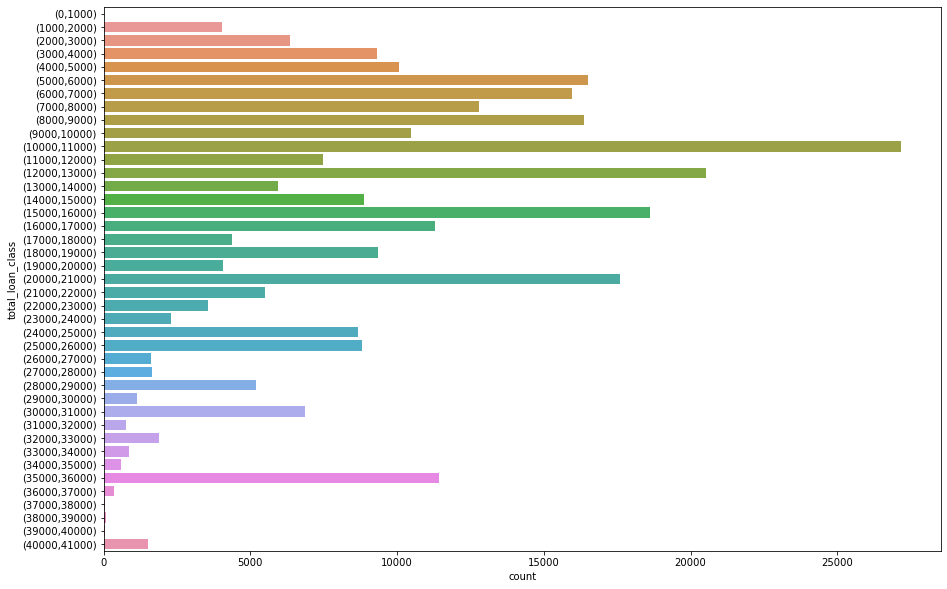

In [48]:
plt.figure(figsize=(15, 10))
sns.barplot(respd['count'], respd['total_loan_class'], orient='h')

# 任务三-1
## 统计所有⽤户所在公司类型 employer_type 的数量分布占⽐情况，输出成 CSV 格式的⽂件

In [8]:
total_employer_type = df.select("employer_type").count()
total_employer_type

300000

In [13]:
df = df.withColumn("employer_type_percent", f.lit(1/total_employer_type))

In [41]:
res = df.select(["employer_type", "employer_type_percent"]).groupBy("employer_type").agg(f.sum("employer_type_percent")).orderBy(f.sum("employer_type_percent"))

In [42]:
res = res.withColumnRenamed('sum(employer_type_percent)','employer_type_percent')

In [43]:
res.show()

+--------------+---------------------+
| employer_type|employer_type_percent|
+--------------+---------------------+
|  高等教育机构|  0.03368666666666739|
|    世界五百强|  0.05370666666666832|
|幼教与中小学校|  0.09998333333332708|
|      上市企业|  0.10012666666666041|
|      政府机构|  0.25815333333336277|
|      普通企业|   0.4543433333334228|
+--------------+---------------------+



In [44]:
res = res.select(['employer_type', f.bround("employer_type_percent", scale=4).alias('employer_type_percent')])

In [45]:
res.show()

+--------------+---------------------+
| employer_type|employer_type_percent|
+--------------+---------------------+
|  高等教育机构|               0.0337|
|    世界五百强|               0.0537|
|幼教与中小学校|                  0.1|
|      上市企业|               0.1001|
|      政府机构|               0.2582|
|      普通企业|               0.4543|
+--------------+---------------------+



In [46]:
res.repartition(1).write.csv("./work3-1", encoding="gbk", header=True)

# 任务三-2
## 统计每个⽤户最终须缴纳的利息⾦额，输出成 CSV 格式的⽂件

In [37]:
df = df.withColumn("year_of_loan", df["year_of_loan"].cast(IntegerType()))
df = df.withColumn("monthly_payment", df["monthly_payment"].cast(FloatType()))
df = df.withColumn("total_loan", df["total_loan"].cast(FloatType()))

In [38]:
df = df.withColumn("total_money", df["year_of_loan"]*df["monthly_payment"]*12-df["total_loan"])

In [47]:
res = df.select(["user_id", "total_money"])

In [48]:
res.show()

+-------+-----------+
|user_id|total_money|
+-------+-----------+
|      0|     3846.0|
|      1|  1840.6006|
|      2|  10465.602|
|      3|  1758.5195|
|      4|  1056.8799|
|      5|  7234.6406|
|      6|   757.9204|
|      7|   4186.959|
|      8|  2030.7598|
|      9|  378.71973|
|     10|  4066.7598|
|     11|  1873.5605|
|     12|  5692.2793|
|     13|  1258.6797|
|     14|  6833.6016|
|     15|   9248.201|
|     16|   6197.121|
|     17|    1312.44|
|     18|   5125.201|
|     19|  1215.8398|
+-------+-----------+
only showing top 20 rows



In [49]:
res.repartition(1).write.csv("./work3-2", encoding="gbk", header=True)

# 任务三-3
## 统计⼯作年限 work_year 超过 5 年的⽤户的房贷情况 censor_status 的数量分布占⽐情况。输出成 CSV 格式的⽂件

In [67]:
def work_year_process(str_value):
    if str_value is None:
        return -1
    elif '10+' in str_value:
        return 11
    elif "<" in str_value:
        return 0
    else:
        str_num = str_value.split(' ')[0]
        return int(str_num)
udf_work_year_process = f.udf(work_year_process, StringType())

In [68]:
df = df.withColumn("work_year_num", udf_work_year_process('work_year'))

In [78]:
res = df.select(['user_id', 'censor_status', 'work_year', 'work_year_num']).filter(df['work_year_num']>5)

In [79]:
res = res.select(['user_id', 'censor_status', 'work_year'])

In [80]:
res.show()

+-------+-------------+---------+
|user_id|censor_status|work_year|
+-------+-------------+---------+
|      1|            2|10+ years|
|      2|            1|10+ years|
|      5|            2|10+ years|
|      6|            0|  8 years|
|      7|            2|10+ years|
|      9|            0|10+ years|
|     10|            2|10+ years|
|     15|            1|  7 years|
|     16|            2|10+ years|
|     17|            0|10+ years|
|     18|            1|10+ years|
|     20|            1|  7 years|
|     21|            2|10+ years|
|     25|            2|10+ years|
|     26|            0|10+ years|
|     30|            0|10+ years|
|     31|            0|  6 years|
|     33|            1|10+ years|
|     38|            0|10+ years|
|     39|            1|10+ years|
+-------+-------------+---------+
only showing top 20 rows



In [81]:
res.repartition(1).write.csv("./work3-3", encoding="gbk", header=True)